# How to perform dimensionality reduction on a mesh?

Goal: get a lower-dimension representation of a mesh that can be fed to a regression model.


Hypotheses:

* vertices are in one-to-one correspondence


Additional requirements:

* pipeline should be invertible

* pipeline must be compatible with `sklearn`


In [1]:
from pathlib import Path

import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing import Map, NestingSwapper, PartiallyInitializedStep
from polpo.preprocessing.load.pregnancy import DenseMaternalMeshLoader
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.mesh.registration import PvAlign
from polpo.sklearn.adapter import AdapterPipeline
from polpo.sklearn.mesh import BiMeshesToVertices
from polpo.sklearn.np import BiFlattenButFirst

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

## Loading meshes

In [3]:
prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: Map(PvAlign(**kwargs)),
    _target=lambda meshes: meshes[0],
    max_iterations=500,
)

In [4]:
subject_id = "01"

file_finder = DenseMaternalMeshLoader(
    subject_id=subject_id,
    as_dict=False,
    left=True,
    struct="Hipp",
)

pipe = file_finder + Map(PvReader()) + prep_pipe

meshes = pipe()

## Create, fit and apply pipeline

In [5]:
pca = PCA(n_components=4)

objs2y = AdapterPipeline(
    steps=[
        BiMeshesToVertices(index=0),
        FunctionTransformer(func=np.stack),
        BiFlattenButFirst(),
        StandardScaler(with_std=False),
        pca,
    ],
)

objs2y

,steps,"[('step_0', ...), ('step_1', ...), ...]"
,index,0
,func,<function sta...x7e385c197bf0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None
,inv_kw_args,None
,copy,True


In [6]:
objs2y.fit(meshes);

Let's look at the explained variance ratio.

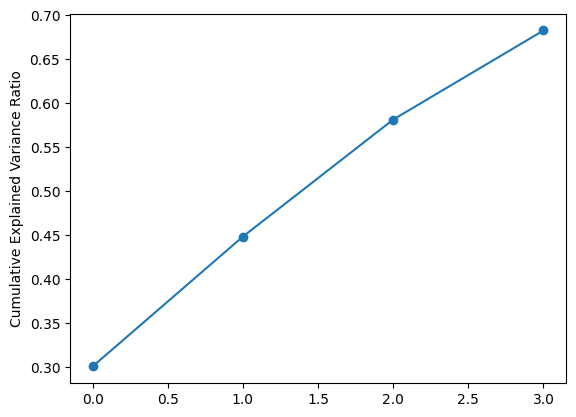

In [7]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")

plt.ylabel("Cumulative Explained Variance Ratio");

## Visualize changes along the PCA axes

This is how the hippocampus changes when we move along the PCA axes.

In [8]:
comps = objs2y.transform(meshes)

mean_comps = comps.mean(axis=0)

rec_meshes = []
for comp_index in range(4):
    sel_comps = comps[:, comp_index]

    min_sel_comp, max_sel_comp = np.min(sel_comps), np.max(sel_comps)

    var_comp = np.linspace(min_sel_comp, max_sel_comp, num=10)

    X = np.broadcast_to(mean_comps, (len(var_comp), comps.shape[1])).copy()
    X[:, comp_index] = var_comp

    rec_meshes.append(objs2y.inverse_transform(X))

rec_meshes = NestingSwapper()(rec_meshes)

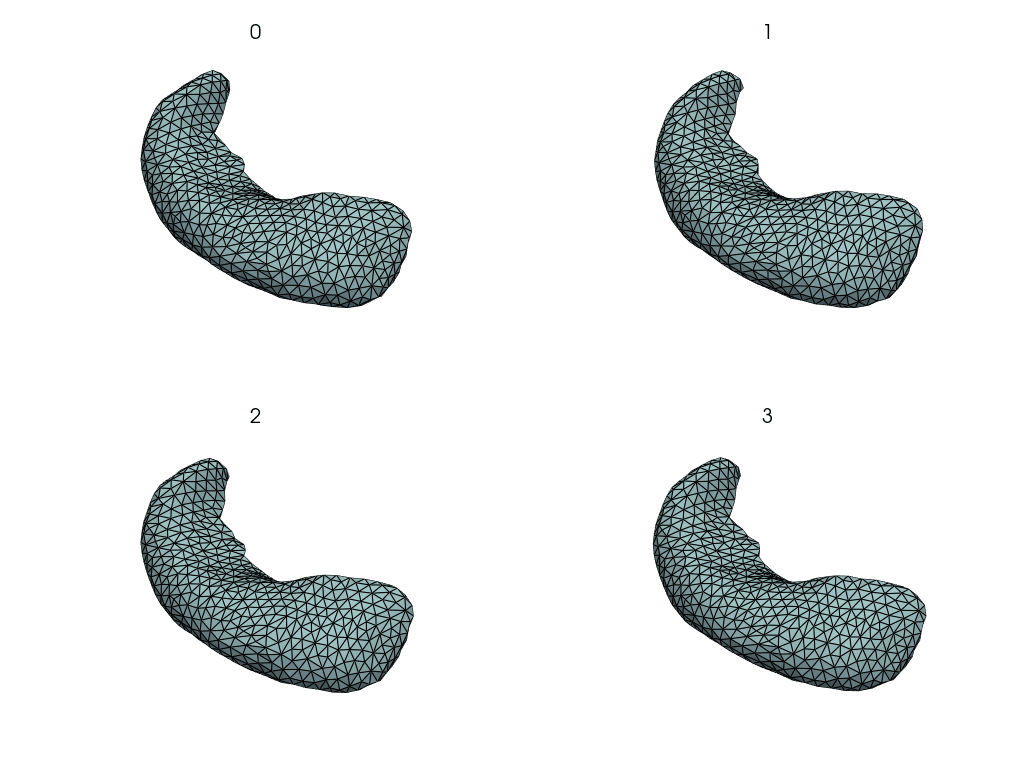

In [9]:
outputs_dir = Path("_images")
outputs_dir.mkdir(exist_ok=True)

gif_name = outputs_dir / "pca.gif"

pl = RegisteredMeshesGifPlotter(
    shape=(2, 2),
    gif_name=gif_name.as_posix(),
    fps=3,
    border=False,
    off_screen=True,
    notebook=False,
    subtitle=True,
)

pl.add_meshes(rec_meshes)
pl.close()

pl.show()

## Further reading

* [How to do mesh-valued regression?](./mesh_valued_regression.ipynb)